# **Experiments**:

In [132]:
# anomaly detector function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import OneClassSVM
from datetime import date,datetime, timedelta
from tensorflow.keras.callbacks import EarlyStopping

def anomaly_detection(data) :
  # Assuming 'XX' is one of your expense categories
  expense_data = data
  expense_data = expense_data[['Date', 'Amount']]
  expense_data = expense_data.groupby('Date')['Amount'].sum().reset_index()

  # Convert 'Date' to datetime and set it as the index
  expense_data['Date'] = pd.to_datetime(expense_data['Date'])
  expense_data.set_index('Date', inplace=True)

  # Normalize the data
  scaler = MinMaxScaler()
  normalized_data = scaler.fit_transform(expense_data[['Amount']])
  expense_data['Normalized_Amount'] = normalized_data

  # Define a function to create sequences for training the LSTM autoencoder
  def create_sequences(data, sequence_length):
      sequences = []
      for i in range(len(data) - sequence_length):
          sequence = data[i:i + sequence_length]
          sequences.append(sequence)
      return np.array(sequences)

  # Set the sequence length (adjust as needed)
  sequence_length = 10

  # Create sequences for training the autoencoder
  sequences = create_sequences(expense_data['Normalized_Amount'].values, sequence_length)

  # Build the LSTM autoencoder model
  model = Sequential()
  model.add(LSTM(units=50, activation='relu', input_shape=(sequence_length, 1), return_sequences=True))
  model.add(LSTM(units=25, activation='relu', return_sequences=False))
  model.add(Dense(units=sequence_length, activation='linear'))
  model.compile(optimizer='adam', loss='mse')

  # Reshape the data for LSTM input (samples, time steps, features)
  sequences = sequences.reshape((sequences.shape[0], sequences.shape[1], 1))
  print(sequences.shape)


  early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

  # Train the autoencoder and get the training history
  history = model.fit(sequences, sequences, epochs=50, batch_size=32, validation_split=0.1, verbose=1, callbacks=[early_stopping])

  # Make predictions on the training set
  reconstructed_sequences = model.predict(sequences)

  # Calculate reconstruction error
  reconstruction_error = np.mean(np.abs(sequences.squeeze() - reconstructed_sequences.squeeze()), axis=1)

  # Set a threshold for anomaly detection (adjust as needed)
  threshold = 2 * np.std(reconstruction_error)
  # threshold = 3 * np.std(reconstruction_error)  # Adjust the multiplier

  # Use OC-SVM for anomaly detection
  # You can adjust the hyperparameter 'nu'

  # oc_svm = OneClassSVM(nu=0.05)
  oc_svm = OneClassSVM(nu=0.01)
  # oc_svm = OneClassSVM(nu=0.01, kernel='rbf')  # Try different kernel functions
  # oc_svm = OneClassSVM(nu=0.01, kernel='rbf', gamma=0.1)  # Adjust the value of 'gamma'
  # oc_svm = OneClassSVM(nu=0.05, kernel='rbf', gamma='scale')  # Adjust the value of 'gamma'

  oc_svm.fit(reconstruction_error.reshape(-1, 1))

  # Predict outliers with OC-SVM
  outliers = oc_svm.predict(reconstruction_error.reshape(-1, 1))

  # Identify anomalies based on the OC-SVM predictions
  anomalies = expense_data.index[sequence_length:][outliers == -1]

  # Plot the time series data and highlight anomalies
  plt.figure(figsize=(16, 8))
  plt.plot(expense_data.index[sequence_length:], expense_data['Amount'].values[sequence_length:], label='Time Series Data')
  plt.scatter(anomalies, expense_data['Amount'].loc[anomalies], color='red', label='Anomalies')
  plt.title('LSTM Autoencoder + OC-SVM Anomaly Detection')
  plt.xlabel('Date')
  plt.ylabel('Amount')
  plt.legend()
  plt.show()

  # Extract training and validation loss from the history
  training_loss = history.history['loss']
  validation_loss = history.history['val_loss']

  # Plot the training and validation loss
  plt.figure(figsize=(12, 6))
  plt.plot(training_loss, label='Training Loss', color='blue')
  plt.plot(validation_loss, label='Validation Loss', color='orange')
  plt.title('Training and Validation Loss Over Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  return  expense_data.loc[anomalies].sort_values(by='Amount', ascending=False).reset_index()


In [133]:
goal_amount = 12000
goal_days = 90
monthly_income = 250000
daily_income = monthly_income/30
total_income_until_goal = daily_income*goal_days

# get previous expense from firestore
pre_food_expenses_df = []
pre_medical_expenses_df = []
pre_transport_expenses_df = []
pre_housingandbills_expenses_df = []
pre_personalcare_expenses_df = []

# get user threshold values from firestore
p1_threshold = 200
p2_threshold = 750
p3_threshold = 500
p4_threshold = 400
p5_threshold = 500

# Use datetime.combine to combine date with midnight time
current_date = datetime.combine(date.today(), datetime.min.time())
current_date = datetime.combine(datetime(year=2022, month=3, day=2, hour=0, minute=0, second=0), datetime.min.time())


# Format the datetime object as a string
formatted_current_date = current_date.strftime('%Y-%m-%d %H:%M:%S')

In [134]:
# set user priority
pre_medical_expenses_df = pd.read_csv('/content/drive/MyDrive/4th year Research/Implementation/LSTM Prediction/DATA SCIENCE/Final v1.0/other_data.csv')
pre_food_expenses_df = pd.read_csv('/content/drive/MyDrive/4th year Research/Implementation/LSTM Prediction/DATA SCIENCE/Final v1.0/food_data.csv')
pre_transport_expenses_df = pd.read_csv('/content/drive/MyDrive/4th year Research/Implementation/LSTM Prediction/DATA SCIENCE/Final v1.0/transportation_data.csv')
pre_personalcare_expenses_df = pd.read_csv('/content/drive/MyDrive/4th year Research/Implementation/LSTM Prediction/DATA SCIENCE/Final v1.0/personalcare_data.csv')
# pre_personalcare_expenses_df = pd.read_csv('/content/drive/MyDrive/4th year Research/Implementation/LSTM Prediction/DATA SCIENCE/Final v1.0/other_data.csv')
pre_housingandbills_expenses_df = pd.read_csv('/content/drive/MyDrive/4th year Research/Implementation/LSTM Prediction/DATA SCIENCE/Final v1.0/housing_data.csv')
# pre_housingandbills_expenses_df = pd.read_csv('/content/drive/MyDrive/4th year Research/Implementation/LSTM Prediction/DATA SCIENCE/Final v1.0/other_data.csv')


In [135]:
print(pre_medical_expenses_df)

          Date    Amount
0   2021-11-21   2000.00
1   2021-11-30    115.00
2   2021-12-04     30.00
3   2021-12-11    240.00
4   2021-12-17     50.00
5   2021-12-18   1063.72
6   2021-12-19    100.00
7   2021-12-24    150.00
8   2021-12-27    120.00
9   2021-12-30    550.00
10  2022-01-02      8.00
11  2022-01-03    646.00
12  2022-01-04   1480.00
13  2022-01-05   1070.00
14  2022-01-06    440.00
15  2022-01-08    260.00
16  2022-01-12    679.00
17  2022-01-13   1000.00
18  2022-01-14   1160.00
19  2022-01-15   1500.00
20  2022-01-18   1200.00
21  2022-01-21    200.00
22  2022-01-23   2510.00
23  2022-01-26    125.00
24  2022-01-27   2200.00
25  2022-01-29    100.00
26  2022-01-31    200.00
27  2022-02-02    500.00
28  2022-02-03    150.00
29  2022-02-06   6500.00
30  2022-02-08   1000.00
31  2022-02-12  10000.00
32  2022-02-13    100.00
33  2022-02-19     50.00
34  2022-02-26   3300.00
35  2022-02-28    200.00
36  2022-03-01    600.00
37  2022-03-02    300.00


In [136]:
print(pre_food_expenses_df)

          Date  Amount
0   2021-11-21  875.00
1   2021-11-22  187.00
2   2021-11-23  179.00
3   2021-11-24  105.00
4   2021-11-25  240.00
..         ...     ...
73  2022-02-26  149.00
74  2022-02-27  243.00
75  2022-02-28  339.15
76  2022-03-01  145.00
77  2022-03-02   50.00

[78 rows x 2 columns]


In [137]:
print(pre_transport_expenses_df)

          Date  Amount
0   2021-11-21   130.0
1   2021-11-23    50.0
2   2021-11-24    58.0
3   2021-11-25    58.0
4   2021-11-27    35.0
5   2021-12-20    80.0
6   2021-12-25   306.0
7   2021-12-30   528.0
8   2022-01-02   725.0
9   2022-01-05    60.0
10  2022-01-06    42.0
11  2022-01-13    43.0
12  2022-01-15  1365.0
13  2022-01-25   325.0
14  2022-01-27    43.0
15  2022-01-29    44.0
16  2022-01-31   203.0
17  2022-02-06  1000.0
18  2022-02-07   214.0
19  2022-02-19  2105.0
20  2022-02-21  1639.8
21  2022-02-22   120.0
22  2022-03-01    30.0


In [138]:
print(pre_personalcare_expenses_df)

          Date   Amount
0   2021-11-30   115.00
1   2021-12-01   196.00
2   2021-12-18   363.72
3   2021-12-19   363.72
4   2021-12-24    50.00
5   2021-12-25   400.00
6   2021-12-26   363.72
7   2021-12-28   150.00
8   2021-12-30   400.00
9   2021-01-01   150.00
10  2021-01-03   400.00
11  2022-01-04  1400.00
12  2022-01-23   200.00
13  2022-02-13   100.00
14  2022-02-26  1700.00


In [139]:
print(pre_housingandbills_expenses_df)

          Date  Amount
0   2021-12-05  4800.0
1   2022-01-08  4580.0
2   2022-01-09  2100.0
3   2022-01-10  1500.0
4   2022-01-12   145.0
5   2022-01-15   780.0
6   2022-01-16   560.0
7   2022-01-18  1800.0
8   2022-01-21   150.0
9   2022-01-25  1200.0
10  2022-02-28  2099.0
11  2022-02-12    70.0
12  2022-02-21   336.0
13  2022-02-24   303.0


(28, 10, 1)
Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 0.0299 - val_loss: 0.1552
Epoch 2/50
1/1 [==============================] - 0s 50ms/step - loss: 0.0295 - val_loss: 0.1543
Epoch 3/50
1/1 [==============================] - 0s 54ms/step - loss: 0.0292 - val_loss: 0.1536
Epoch 4/50
1/1 [==============================] - 0s 45ms/step - loss: 0.0289 - val_loss: 0.1529
Epoch 5/50
1/1 [==============================] - 0s 46ms/step - loss: 0.0286 - val_loss: 0.1522
Epoch 6/50
1/1 [==============================] - 0s 47ms/step - loss: 0.0283 - val_loss: 0.1516
Epoch 7/50
1/1 [==============================] - 0s 49ms/step - loss: 0.0280 - val_loss: 0.1509
Epoch 8/50
1/1 [==============================] - 0s 51ms/step - loss: 0.0277 - val_loss: 0.1503
Epoch 9/50
1/1 [==============================] - 0s 48ms/step - loss: 0.0274 - val_loss: 0.1497
Epoch 10/50
1/1 [==============================] - 0s 54ms/step - loss: 0.0271 - val_loss: 0.1491
Epoch 11/50
1/1 [==

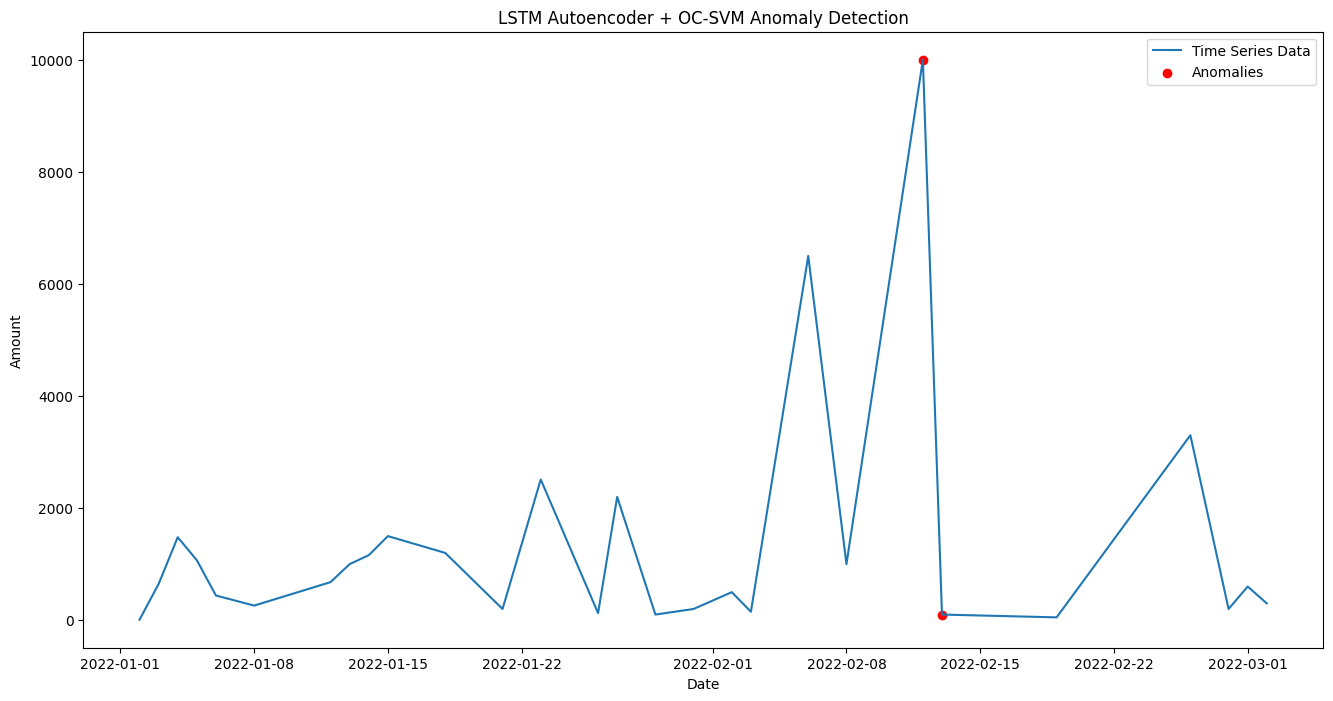

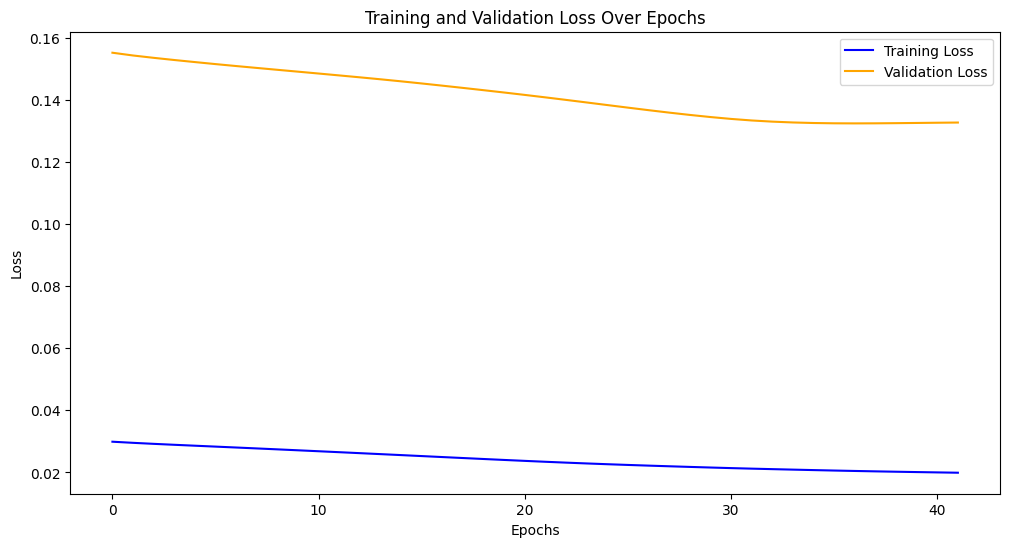

                  Date   Amount  Normalized_Amount
0  2022-02-12 00:00:00  10000.0           1.000000
2  2022-03-02 00:00:00    200.0                NaN
1  2022-02-13 00:00:00    100.0           0.009207
(68, 10, 1)
Epoch 1/50
2/2 [==============================] - 4s 423ms/step - loss: 0.0734 - val_loss: 0.0721
Epoch 2/50
2/2 [==============================] - 0s 59ms/step - loss: 0.0712 - val_loss: 0.0700
Epoch 3/50
2/2 [==============================] - 0s 47ms/step - loss: 0.0698 - val_loss: 0.0684
Epoch 4/50
2/2 [==============================] - 0s 49ms/step - loss: 0.0685 - val_loss: 0.0666
Epoch 5/50
2/2 [==============================] - 0s 47ms/step - loss: 0.0673 - val_loss: 0.0648
Epoch 6/50
2/2 [==============================] - 0s 52ms/step - loss: 0.0659 - val_loss: 0.0629
Epoch 7/50
2/2 [==============================] - 0s 53ms/step - loss: 0.0645 - val_loss: 0.0608
Epoch 8/50
2/2 [==============================] - 0s 48ms/step - loss: 0.0631 - val_loss: 0.0587
Epoch 9

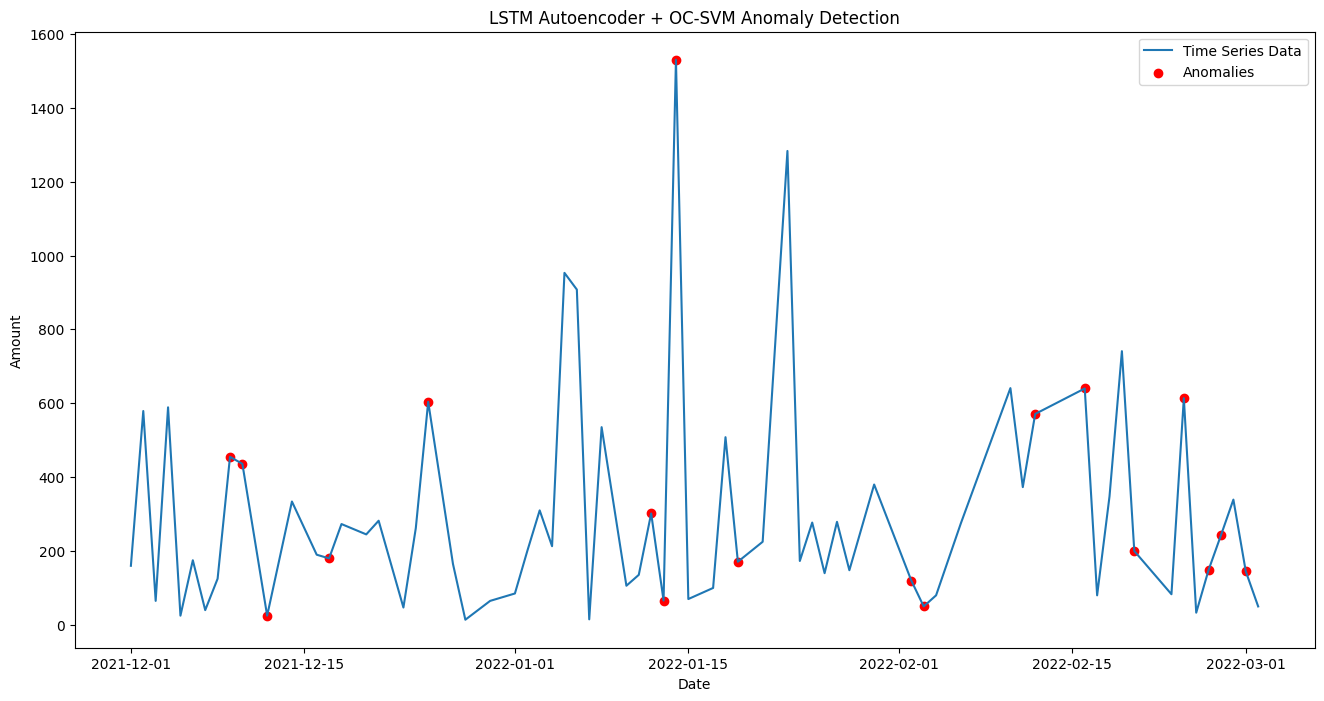

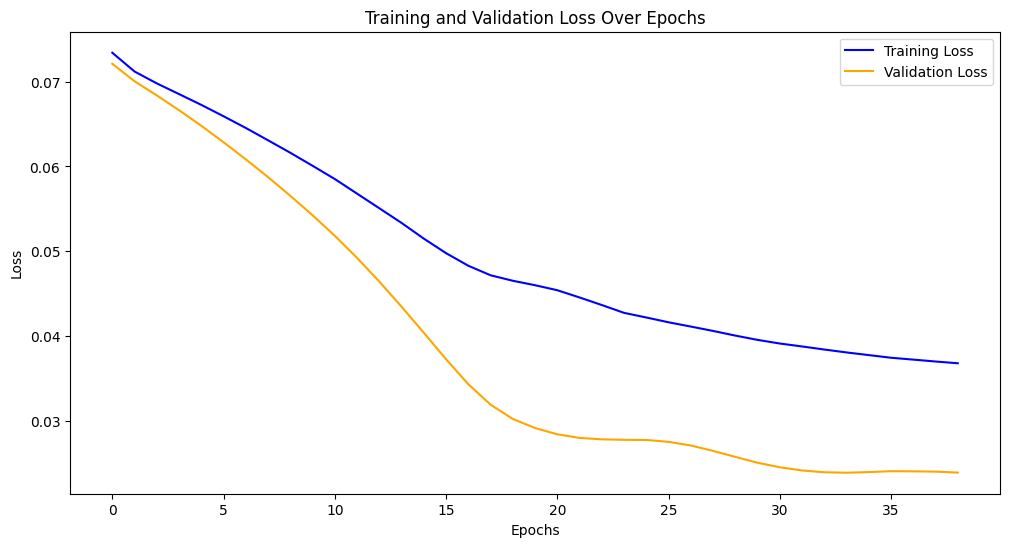

                   Date   Amount  Normalized_Amount
0   2022-01-14 00:00:00  1530.00           1.000000
18  2022-03-02 00:00:00   750.00                NaN
1   2022-02-16 00:00:00   640.00           0.412929
2   2022-02-24 00:00:00   613.70           0.395580
3   2021-12-25 00:00:00   604.00           0.389182
4   2022-02-12 00:00:00   571.00           0.367414
5   2021-12-09 00:00:00   455.00           0.290897
6   2021-12-10 00:00:00   436.00           0.278364
7   2022-01-12 00:00:00   301.75           0.189809
8   2022-02-27 00:00:00   243.00           0.151055
9   2022-02-20 00:00:00   200.00           0.122691
10  2021-12-17 00:00:00   180.00           0.109499
11  2022-01-19 00:00:00   171.00           0.103562
12  2022-02-26 00:00:00   149.00           0.089050
13  2022-03-01 00:00:00   145.00           0.086412
14  2022-02-02 00:00:00   120.00           0.069921
15  2022-01-13 00:00:00    66.00           0.034301
16  2022-02-03 00:00:00    50.00           0.023747
17  2021-12-

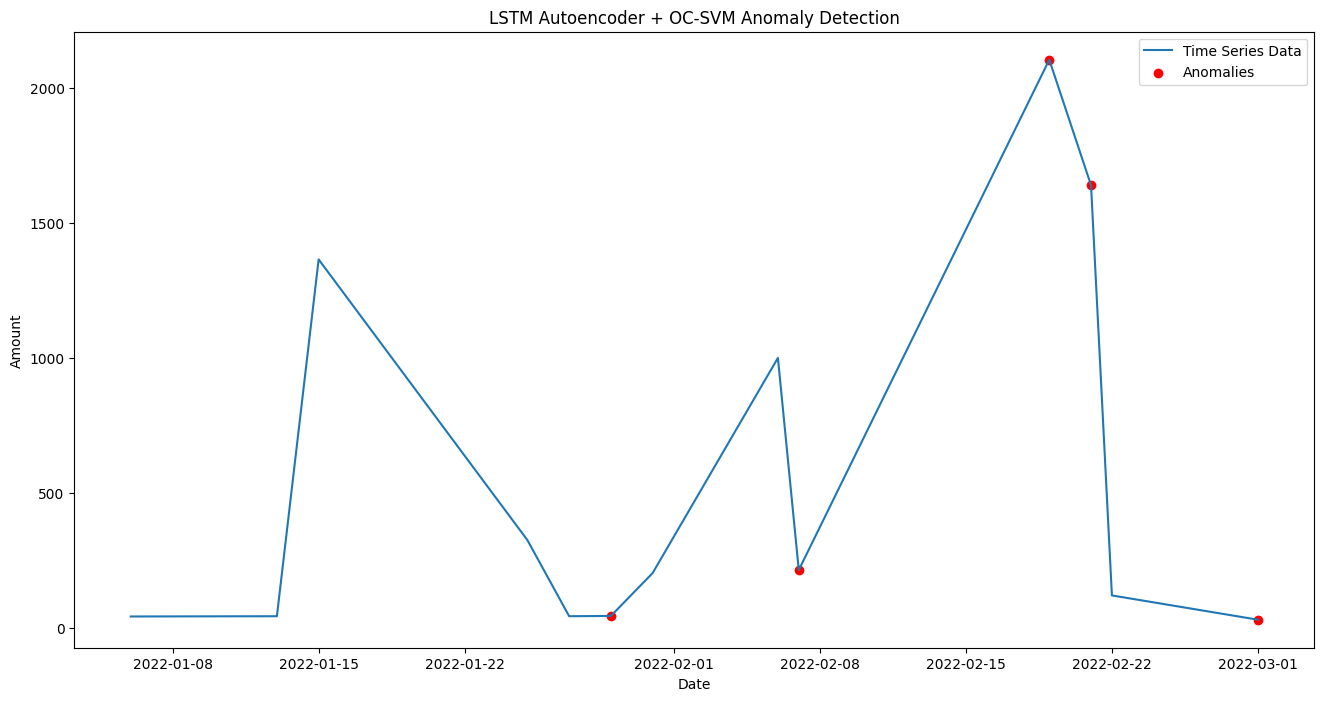

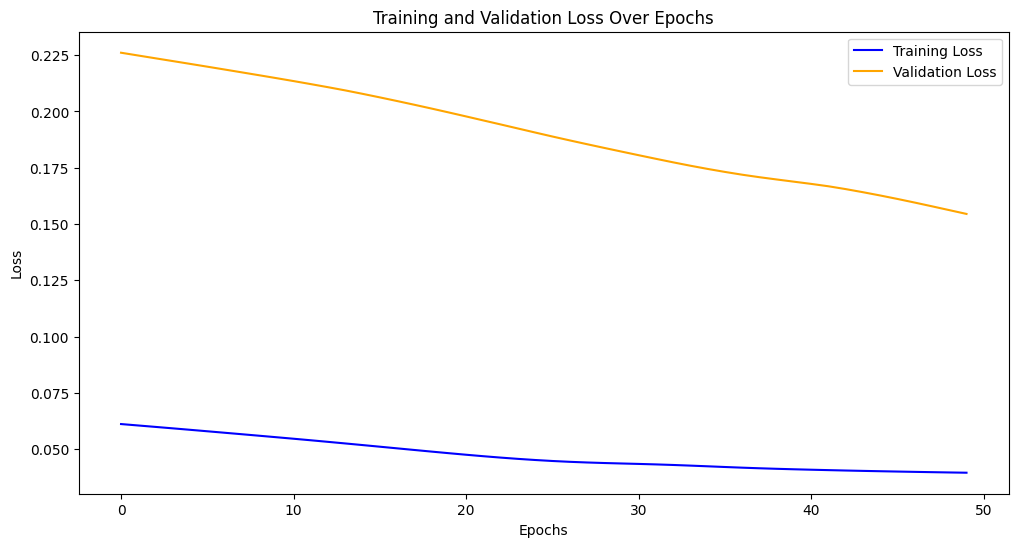

                  Date  Amount  Normalized_Amount
0  2022-02-19 00:00:00  2105.0           1.000000
1  2022-02-21 00:00:00  1639.8           0.775807
5  2022-03-02 00:00:00   500.0                NaN
2  2022-02-07 00:00:00   214.0           0.088675
3  2022-01-29 00:00:00    44.0           0.006747
4  2022-03-01 00:00:00    30.0           0.000000
(4, 10, 1)
Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 0.1407 - val_loss: 0.0299
Epoch 2/50
1/1 [==============================] - 0s 62ms/step - loss: 0.1391 - val_loss: 0.0290
Epoch 3/50
1/1 [==============================] - 0s 51ms/step - loss: 0.1373 - val_loss: 0.0280
Epoch 4/50
1/1 [==============================] - 0s 58ms/step - loss: 0.1354 - val_loss: 0.0270
Epoch 5/50
1/1 [==============================] - 0s 59ms/step - loss: 0.1335 - val_loss: 0.0260
Epoch 6/50
1/1 [==============================] - 0s 57ms/step - loss: 0.1314 - val_loss: 0.0249
Epoch 7/50
1/1 [==============================] - 0s 63ms/s

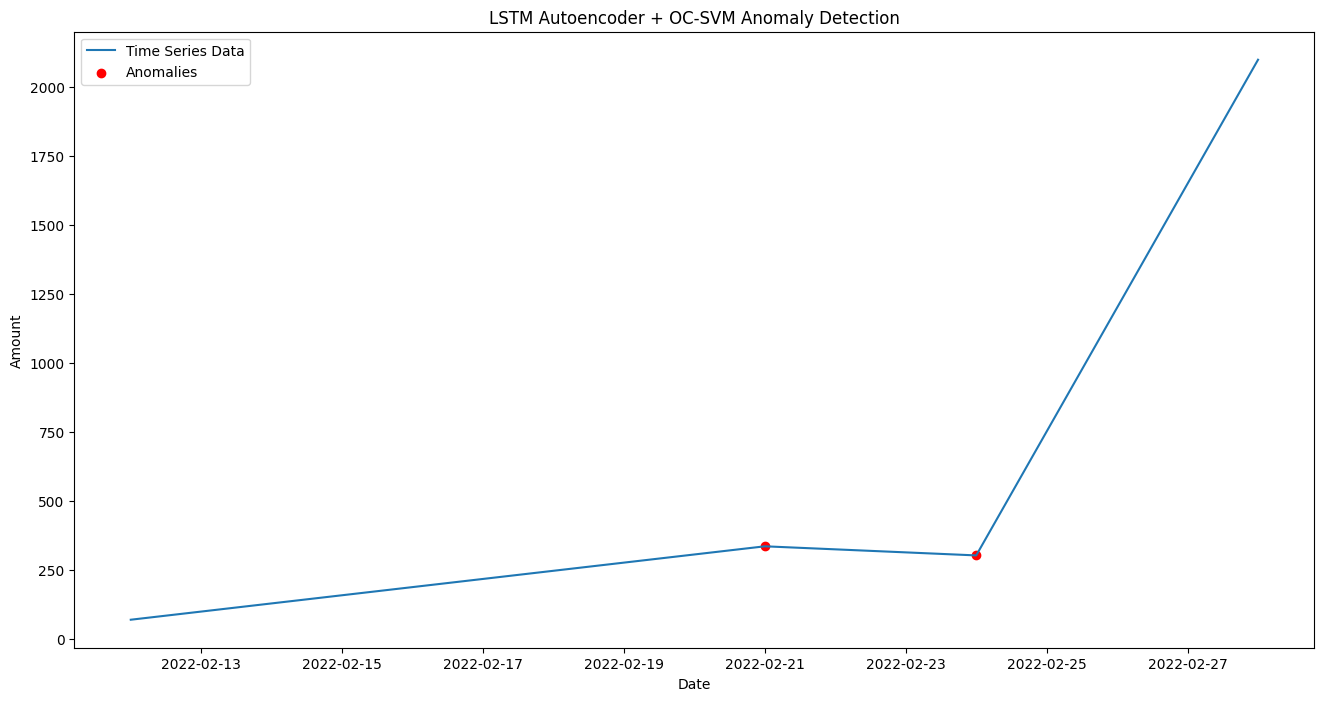

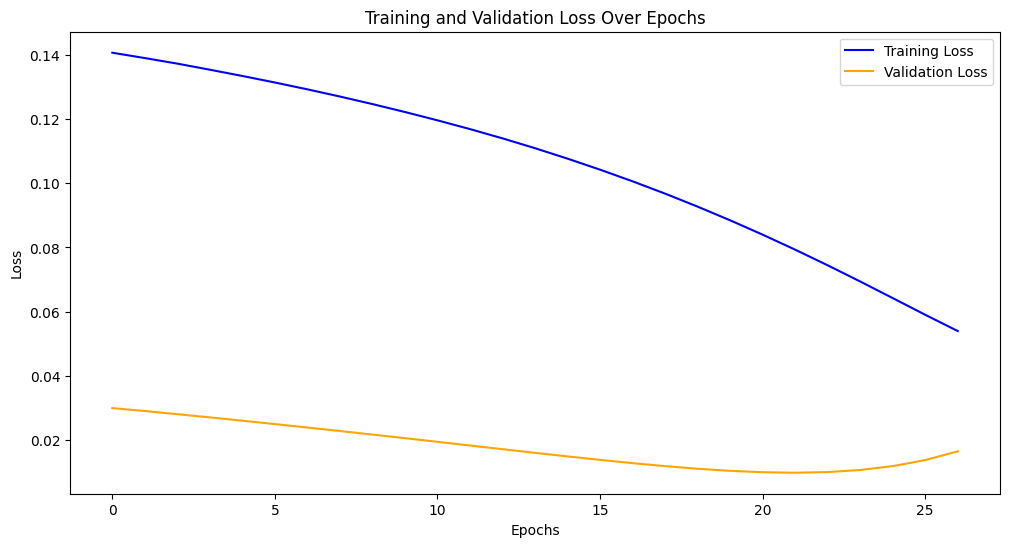

                  Date  Amount  Normalized_Amount
2  2022-03-02 00:00:00   400.0                NaN
0  2022-02-21 00:00:00   336.0           0.056237
1  2022-02-24 00:00:00   303.0           0.049260
(5, 10, 1)
Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 0.0560 - val_loss: 0.0881
Epoch 2/50
1/1 [==============================] - 0s 69ms/step - loss: 0.0550 - val_loss: 0.0877
Epoch 3/50
1/1 [==============================] - 0s 72ms/step - loss: 0.0542 - val_loss: 0.0872
Epoch 4/50
1/1 [==============================] - 0s 110ms/step - loss: 0.0534 - val_loss: 0.0867
Epoch 5/50
1/1 [==============================] - 0s 85ms/step - loss: 0.0526 - val_loss: 0.0862
Epoch 6/50
1/1 [==============================] - 0s 99ms/step - loss: 0.0519 - val_loss: 0.0856
Epoch 7/50
1/1 [==============================] - 0s 110ms/step - loss: 0.0511 - val_loss: 0.0850
Epoch 8/50
1/1 [==============================] - 0s 82ms/step - loss: 0.0504 - val_loss: 0.0844
Epoch 9/50
1/

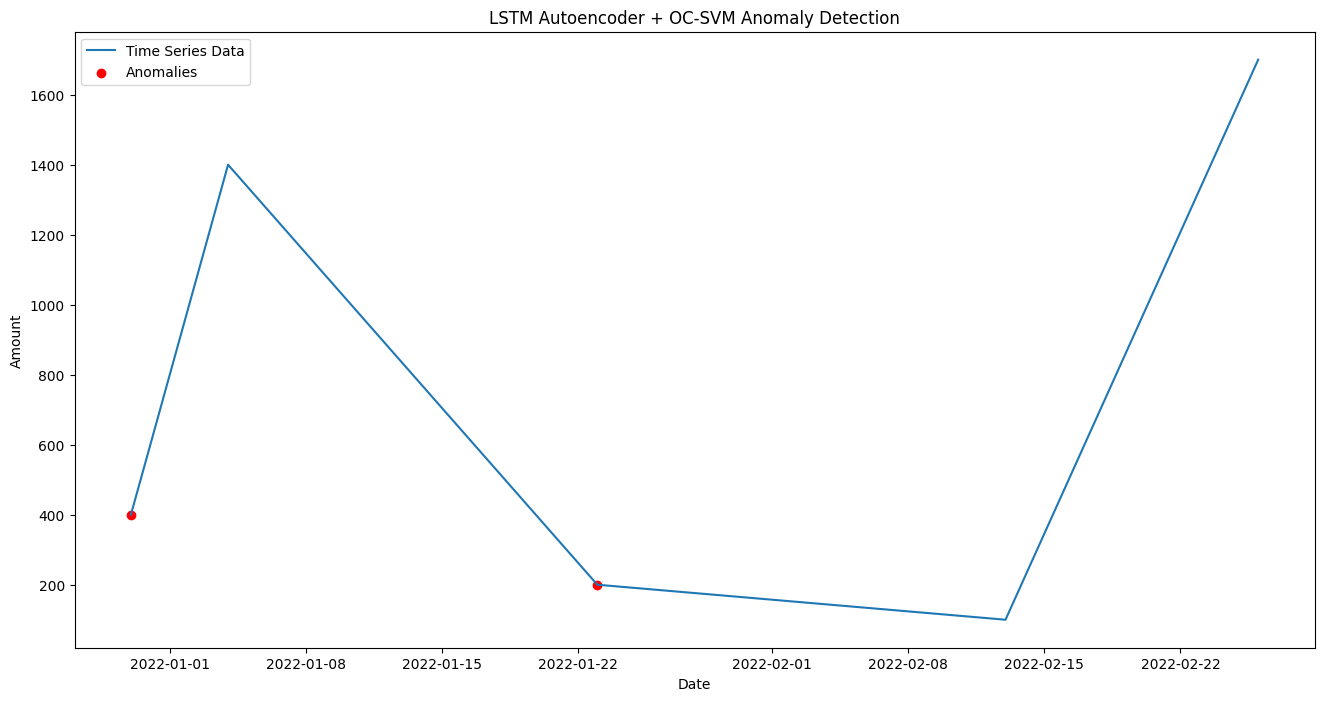

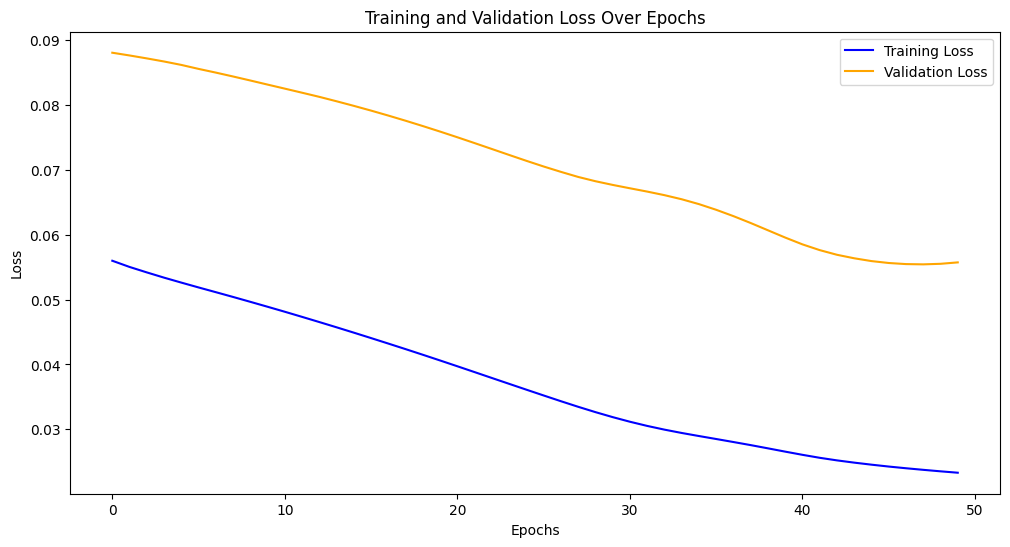

                  Date  Amount  Normalized_Amount
2  2022-03-02 00:00:00   500.0                NaN
0  2021-12-30 00:00:00   400.0           0.212121
1  2022-01-23 00:00:00   200.0           0.090909


In [140]:
p1 = anomaly_detection(pre_medical_expenses_df)

p1_new_data = {'Date': [formatted_current_date],'Amount': [p1_threshold]}
p1_new_df = pd.DataFrame(p1_new_data)
p1 = pd.concat([p1, p1_new_df], ignore_index=True).sort_values(by='Amount', ascending=False)
print(p1);
# ---------------------------------------------------------------------------
p2 = anomaly_detection(pre_food_expenses_df)

p2_new_data = {'Date': [formatted_current_date],'Amount': [p2_threshold]}
p2_new_df = pd.DataFrame(p2_new_data)
p2 = pd.concat([p2, p2_new_df], ignore_index=True).sort_values(by='Amount', ascending=False)
print(p2)
# ---------------------------------------------------------------------------

p3 = anomaly_detection(pre_transport_expenses_df)

p3_new_data = {'Date': [formatted_current_date],'Amount': [p3_threshold]}
p3_new_df = pd.DataFrame(p3_new_data)
p3 = pd.concat([p3, p3_new_df], ignore_index=True).sort_values(by='Amount', ascending=False)
print(p3);
# ---------------------------------------------------------------------------

p4 = anomaly_detection(pre_housingandbills_expenses_df)

p4_new_data = {'Date': [formatted_current_date],'Amount': [p4_threshold]}
p4_new_df = pd.DataFrame(p4_new_data)
p4 = pd.concat([p4, p4_new_df], ignore_index=True).sort_values(by='Amount', ascending=False)
print(p4);
# ---------------------------------------------------------------------------

p5 = anomaly_detection(pre_personalcare_expenses_df)

p5_new_data = {'Date': [formatted_current_date],'Amount': [p5_threshold]}
p5_new_df = pd.DataFrame(p5_new_data)
p5 = pd.concat([p5, p5_new_df], ignore_index=True).sort_values(by='Amount', ascending=False)
print(p5);



In [141]:
total_predicted_expenses = 0

In [142]:
p1_expense_sum = 0
p2_expense_sum = 0
p3_expense_sum = 0
p4_expense_sum = 0
p5_expense_sum = 0

In [143]:
print(p1);
print(p2);
print(p3);
print(p4);
print(p5);

                  Date   Amount  Normalized_Amount
0  2022-02-12 00:00:00  10000.0           1.000000
2  2022-03-02 00:00:00    200.0                NaN
1  2022-02-13 00:00:00    100.0           0.009207
                   Date   Amount  Normalized_Amount
0   2022-01-14 00:00:00  1530.00           1.000000
18  2022-03-02 00:00:00   750.00                NaN
1   2022-02-16 00:00:00   640.00           0.412929
2   2022-02-24 00:00:00   613.70           0.395580
3   2021-12-25 00:00:00   604.00           0.389182
4   2022-02-12 00:00:00   571.00           0.367414
5   2021-12-09 00:00:00   455.00           0.290897
6   2021-12-10 00:00:00   436.00           0.278364
7   2022-01-12 00:00:00   301.75           0.189809
8   2022-02-27 00:00:00   243.00           0.151055
9   2022-02-20 00:00:00   200.00           0.122691
10  2021-12-17 00:00:00   180.00           0.109499
11  2022-01-19 00:00:00   171.00           0.103562
12  2022-02-26 00:00:00   149.00           0.089050
13  2022-03-01 0

In [144]:
def expense_sum(anomaly_value) :
  expense_sum = goal_days*anomaly_value
  print("expense_sum : ",expense_sum)
  return expense_sum


In [149]:
break_all_loops = False

# 5th category
for index, row in p5.iterrows():
  if break_all_loops:
        break
  date5 = row['Date']
  amount5 = row['Amount']
  print("Reach ------------------------------------------------------- (p5)")
  if(amount5<p5_threshold) :
    print("Can't achieve goal, Need Invesment plan !!!")
    break
  else :
    p5_expense_sum = expense_sum(amount5)

  if((p1_expense_sum+p2_expense_sum+p3_expense_sum+p4_expense_sum+p5_expense_sum)>total_income_until_goal) :
    print("Total expenses 5: ", (p1_expense_sum+p2_expense_sum+p3_expense_sum+p4_expense_sum+p5_expense_sum),"Total income till goal",total_income_until_goal)
    print("Can't !!! (p5)")
    if(amount5!=p5_threshold) :
      p5_expense_sum = 0
    continue # try with next anomaly
  else :
    print("Total expenses 5: ", (p1_expense_sum+p2_expense_sum+p3_expense_sum+p4_expense_sum+p5_expense_sum),"Total income till goal",total_income_until_goal)
    print("Can !!! (p5)")

  # 4th category
  for index, row in p4.iterrows():
    if break_all_loops:
        break
    date4 = row['Date']
    amount4 = row['Amount']
    print("Reach ------------------------------------------------------- (p4)")

    if(amount4<p4_threshold) :
       break
    else :
      p4_expense_sum = expense_sum(amount4)

    if((p1_expense_sum+p2_expense_sum+p3_expense_sum+p4_expense_sum+p5_expense_sum)>total_income_until_goal) :
      print("Total expenses 4: ", (p1_expense_sum+p2_expense_sum+p3_expense_sum+p4_expense_sum+p5_expense_sum),"Total income till goal",total_income_until_goal)
      print("Can't !!! (p4)")
      if(amount4!=p4_threshold) :
        p4_expense_sum = 0
      continue # try with next anomaly
    else :
      print("Total expenses 4: ", (p1_expense_sum+p2_expense_sum+p3_expense_sum+p4_expense_sum+p5_expense_sum),"Total income till goal",total_income_until_goal)
      print("Can !!! (p4)")

    # 3rd category
    for index, row in p3.iterrows():
      if break_all_loops:
        break
      date3 = row['Date']
      amount3 = row['Amount']
      print("Reach ------------------------------------------------------- (p3)")
      if(amount3<p3_threshold) :
        break
      else :
        p3_expense_sum = expense_sum(amount3)

      if((p1_expense_sum+p2_expense_sum+p3_expense_sum+p4_expense_sum+p5_expense_sum)>total_income_until_goal) :
        print("Total expenses 3: ", (p1_expense_sum+p2_expense_sum+p3_expense_sum+p4_expense_sum+p5_expense_sum),"Total income till goal",total_income_until_goal)
        print("Can't !!! (p3)")
        if(amount3!=p3_threshold) :
          p3_expense_sum = 0
        continue # try with next anomaly
      else :
        print("Total expenses 3: ", (p1_expense_sum+p2_expense_sum+p3_expense_sum+p4_expense_sum+p5_expense_sum),"Total income till goal",total_income_until_goal)
        print("Can !!! (p3)")

      # 2nd category
      for index, row in p2.iterrows():
        if break_all_loops:
          break
        date2 = row['Date']
        amount2 = row['Amount']
        print("Reach ------------------------------------------------------- (p2)")

        if(amount2<p2_threshold) :
          break
        else :
          p2_expense_sum = expense_sum(amount2)

        if((p1_expense_sum+p2_expense_sum+p3_expense_sum+p4_expense_sum+p5_expense_sum)>total_income_until_goal) :
          print("Total expenses 2: ", (p1_expense_sum+p2_expense_sum+p3_expense_sum+p4_expense_sum+p5_expense_sum),"Total income till goal",total_income_until_goal)
          print("Can't !!! (p2)")
          if(amount2!=p2_threshold) :
            p2_expense_sum = 0
          continue # try with next anomaly
        else :
          print("Total expenses 2: ", (p1_expense_sum+p2_expense_sum+p3_expense_sum+p4_expense_sum+p5_expense_sum),"Total income till goal",total_income_until_goal)
          print("Can !!! (p2)")

        # 1st category
        for index, row in p1.iterrows():
          if break_all_loops:
            break
          date1 = row['Date']
          amount1 = row['Amount']
          print("Reach ------------------------------------------------------- (p1)")

          if(amount1==p1_threshold) :
            break
          else :
            p1_expense_sum = expense_sum(amount1)

          if((p1_expense_sum+p2_expense_sum+p3_expense_sum+p4_expense_sum+p5_expense_sum)>total_income_until_goal) :
            print("Total expenses 1: ", (p1_expense_sum+p2_expense_sum+p3_expense_sum+p4_expense_sum+p5_expense_sum),"Total income till goal",total_income_until_goal)
            print("Can't !!! (p1)")
            if(amount1!=p1_threshold) :
              p1_expense_sum = 0
            continue # try with next anomaly
          else :
            print("Total expenses 1: ", (p1_expense_sum+p2_expense_sum+p3_expense_sum+p4_expense_sum+p5_expense_sum),"Total income till goal",total_income_until_goal)
            print("Great you can achive your goal by following below rec. (p1)")
            break_all_loops = True



Reach ------------------------------------------------------- (p5)
expense_sum :  45000.0
Total expenses 5:  193500.0 Total income till goal 750000.0
Can !!! (p5)
Reach ------------------------------------------------------- (p4)
expense_sum :  36000.0
Total expenses 4:  193500.0 Total income till goal 750000.0
Can !!! (p4)
Reach ------------------------------------------------------- (p3)
expense_sum :  189450.0
Total expenses 3:  337950.0 Total income till goal 750000.0
Can !!! (p3)
Reach ------------------------------------------------------- (p2)
expense_sum :  137700.0
Total expenses 2:  408150.0 Total income till goal 750000.0
Can !!! (p2)
Reach ------------------------------------------------------- (p1)
expense_sum :  900000.0
Total expenses 1:  1308150.0 Total income till goal 750000.0
Can't !!! (p1)
Reach ------------------------------------------------------- (p1)
Reach ------------------------------------------------------- (p2)
expense_sum :  67500.0
Total expenses 2:  337

In [146]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
